# Transfer Learning with TensorFlow Part 3

Scaling Up (Food Vision mini)
101 total food classes

In [1]:
# Check gpu
!nvidia-smi

Mon Aug 15 11:37:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   39C    P5    19W /  N/A |   1577MiB /  8192MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup Helper Functions

In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

2022-08-15 11:37:57.407044: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.0de2b4431c6572ee74152a7ee0cd3fb1534e4a95.so
2022-08-15 11:37:57.407161: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-08-15 11:37:57.415757: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-08-15 11:37:59.408000: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


## Food 101

Goal: Beat the original Food101 paper with 10% of the training data
### Download Dataset

In [3]:
# Download data
!wget -nc -P ../Downloads/ https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip
unzip_data('../Downloads/101_food_classes_10_percent.zip', '../Downloads')

# Check number of images and subdirectories in the dataset
walk_through_dir('../Downloads/101_food_classes_10_percent')

File ‘../Downloads/101_food_classes_10_percent.zip’ already there; not retrieving.

There are 2 directories and 0 images in '../Downloads/101_food_classes_10_percent'.
There are 101 directories and 0 images in '../Downloads/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../Downloads/101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '../Downloads/101_food_classes_10_percent/test/ravioli'.
There are 0 directories and 250 images in '../Downloads/101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '../Downloads/101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '../Downloads/101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '../Downloads/101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '../Downloads/101_food_classes_10_percent/test/pulled_pork_sandwich'.
There ar

In [4]:
train_dir = '../Downloads/101_food_classes_10_percent/train'
test_dir = '../Downloads/101_food_classes_10_percent/test'

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.


2022-08-15 11:38:10.752696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 11:38:10.753760: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3070 Laptop GPU)
2022-08-15 11:38:11.676666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-15 11:38:11.676719: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2022-08-15 11:38:11.676744: I tensorflow/core/common_runtime/pluggable_device/pluggab

Found 25250 files belonging to 101 classes.


## Training the big model with transfer learning

10% of 101 food classes

Steps:
1. Create a ModelCheckpoint callback
2. Create a data agumentation layer to build data agumentation right into the model
3. Build a headless (no top layers) functional EfficientNetB0 base model
    a. Create a custom output layer
4. Compile
5. Feature extract for 5 full passes 
    a. 5 epochs on the train dataset
    b. Validate on 15% of the test data (to save time)

In [6]:
checkpoint_path = '../checkpoints/101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True,
                                                        save_freq="epoch", #default is save every epoch,
                                                        verbose=1
                                                        )

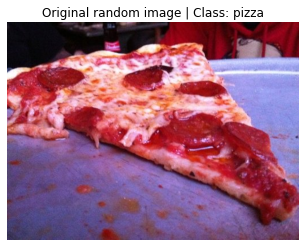

In [7]:
from helper_functions import print_random_img

print_random_img(test_dir, test_data)

In [8]:
# Create data aug layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data aug

with tf.device('/cpu:0'):
    data_aug = Sequential([
        preprocessing.RandomFlip('horizontal'),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
        preprocessing.RandomZoom(0.2),
    #     preprocessing.Rescaling(1/255.), # rescale inputs of images to between 0 & 1. Required for models like resnet50 
    ], name="data_aug")



In [9]:
# Setup base model and freeze
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_aug(inputs) # augment images (only during training)
x = base_model(x, training=False) # put the  base model in inference mode so weights are not updated
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

2022-08-15 11:38:14.412218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-15 11:38:14.412269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2022-08-15 11:38:14.412855: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [10]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy'])


In [11]:
# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5


2022-08-15 11:38:20.944025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:38:21.108844: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-15 11:38:21.110080: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT

237/237 [==============================] - ETA: 0s - loss: 3.3841 - accuracy: 0.2708

2022-08-15 11:39:06.059707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:39:06.133088: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-15 11:39:06.133952: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT


Epoch 1: val_accuracy improved from -inf to 0.46372, saving model to ../checkpoints/101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 57s 205ms/step - loss: 3.3841 - accuracy: 0.2708 - val_loss: 2.4790 - val_accuracy: 0.4637
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.1915 - accuracy: 0.5024
Epoch 2: val_accuracy improved from 0.46372 to 0.51404, saving model to ../checkpoints/101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 44s 187ms/step - loss: 2.1915 - accuracy: 0.5024 - val_loss: 2.0357 - val_accuracy: 0.5140
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8216 - accuracy: 0.5670
Epoch 3: val_accuracy improved from 0.51404 to 0.53681, saving model to ../checkpoints/101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 45s 188ms/step - loss: 1.8216 - accuracy: 0.5670 - val_loss: 1.8641 - val_accuracy: 0.5368
Epoch 4/5
237/

In [12]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 47s 60ms/step - loss: 1.5864 - accuracy: 0.5809


[1.5864077806472778, 0.5809109210968018]

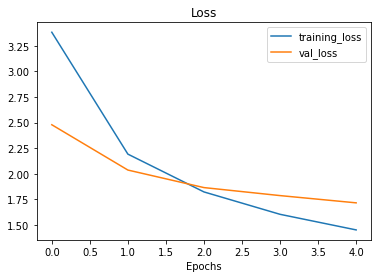

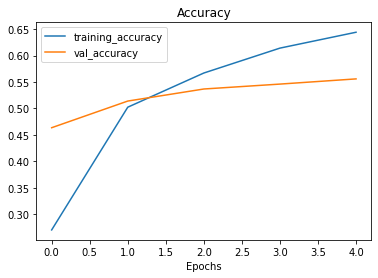

In [13]:
plot_loss_curves(history_all_classes_10_percent)

In [14]:
# Fine Tune
# Unfreeze all the layers in the base_model
base_model.trainable = True

# Refreeze every layer except top 5 layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [15]:
# recompile model, lower learning rate by 10x
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [16]:
# print layer name and index if layer is trainable
for layer_number, layer in enumerate(model.layers[2].layers):
    if layer.trainable:
        print(f'Index: {layer_number}', f'Name: {layer.name}')

Index: 233 Name: block7a_project_conv
Index: 234 Name: block7a_project_bn
Index: 235 Name: top_conv
Index: 236 Name: top_bn
Index: 237 Name: top_activation


In [17]:

fine_tune_epochs = 10

#fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
          epochs=fine_tune_epochs, # fit for 5 epochs to keep experiments quick
          validation_data=test_data,
          validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
          initial_epoch=history_all_classes_10_percent.epoch[-1], # start from the last epoch of the previous training
          ) # save best model weights to file

Epoch 5/10


2022-08-15 11:43:00.399339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:43:00.544819: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node gradient_tape/model/efficientnetb0/top_conv/Conv2D/Conv2DBackpropInput-0-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='XLA_CPU_JIT'; label='host'; T in [DT_INT32, DT_INT64]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-15 11:43:00.546830: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block1a_se_squee

237/237 [==============================] - ETA: 0s - loss: 1.2026 - accuracy: 0.6855

2022-08-15 11:43:40.917733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:43:40.995525: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-15 11:43:40.996210: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT

237/237 [==============================] - 51s 193ms/step - loss: 1.2026 - accuracy: 0.6855 - val_loss: 1.7097 - val_accuracy: 0.5546
Epoch 6/10
237/237 [==============================] - 44s 186ms/step - loss: 1.0880 - accuracy: 0.7075 - val_loss: 1.6826 - val_accuracy: 0.5596
Epoch 7/10
237/237 [==============================] - 44s 184ms/step - loss: 1.0169 - accuracy: 0.7254 - val_loss: 1.7049 - val_accuracy: 0.5551
Epoch 8/10
237/237 [==============================] - 44s 184ms/step - loss: 0.9472 - accuracy: 0.7490 - val_loss: 1.6659 - val_accuracy: 0.5638
Epoch 9/10
237/237 [==============================] - 44s 185ms/step - loss: 0.8870 - accuracy: 0.7616 - val_loss: 1.6686 - val_accuracy: 0.5659
Epoch 10/10
237/237 [==============================] - 44s 185ms/step - loss: 0.8285 - accuracy: 0.7781 - val_loss: 1.7060 - val_accuracy: 0.5564


In [18]:
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 46s 59ms/step - loss: 1.5044 - accuracy: 0.6003


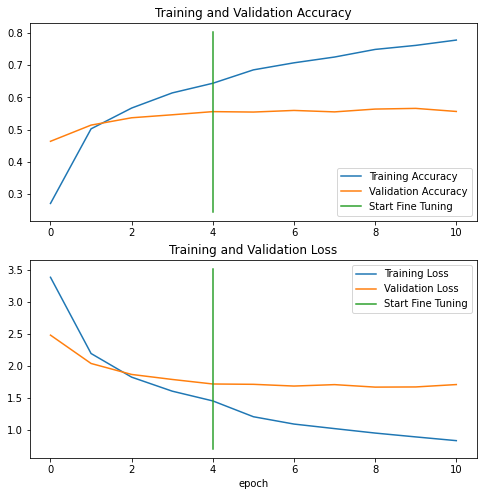

In [19]:
compare_historys(original_history=history_all_classes_10_percent, 
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

## Saving and loading the model

In [20]:
# Save
model.save("../models/101_food_classes_10_percent_data_model")

INFO:tensorflow:Assets written to: ../models/101_food_classes_10_percent_data_model/assets


INFO:tensorflow:Assets written to: ../models/101_food_classes_10_percent_data_model/assets


In [21]:
# Load and evaluate
loaded_model = tf.keras.models.load_model("../models/101_food_classes_10_percent_data_model")

In [22]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

2022-08-15 11:48:48.854682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:48:48.967083: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-15 11:48:48.967906: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT

790/790 [==============================] - 48s 58ms/step - loss: 1.5044 - accuracy: 0.6003


[1.5044126510620117, 0.6003168225288391]

## Evaluating the performance across all different classes

1. Make predictions
2. Visualize
3. Find which predictions were the "most" wrong

In [23]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

2022-08-15 11:49:36.510158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:49:36.579166: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-15 11:49:36.579951: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT

  4/790 [..............................] - ETA: 44s

2022-08-15 11:49:36.873996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-15 11:49:36.874051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2022-08-15 11:49:36.874234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-15 11:49:36.874253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DM

790/790 [==============================] - 45s 56ms/step


In [25]:
# How many predictions
len(preds_probs)

25250

In [26]:
# How many class predictions per image?
# What's the shape of our predictions
preds_probs.shape

(25250, 101)

In [27]:
# check first 10 predictions
preds_probs[:10]

array([[7.69367665e-02, 9.49643203e-04, 3.11053693e-01, ...,
        1.31484385e-05, 2.44061532e-03, 2.26779748e-02],
       [8.13273847e-01, 7.74699629e-08, 2.34720856e-03, ...,
        1.42142130e-02, 1.23241784e-06, 3.48309768e-05],
       [3.52499425e-01, 2.17467770e-02, 5.64798936e-02, ...,
        4.97450877e-04, 5.85156027e-04, 2.36478331e-03],
       ...,
       [1.00071207e-01, 5.30397301e-06, 2.36416189e-03, ...,
        9.99545455e-02, 6.60565507e-04, 1.10650115e-04],
       [1.63901478e-01, 1.03759626e-03, 4.57862765e-01, ...,
        3.95000883e-04, 2.66241521e-04, 2.48743483e-04],
       [6.11728132e-01, 3.81345757e-07, 2.69609806e-03, ...,
        8.79506860e-03, 3.98905968e-06, 1.53563358e-03]], dtype=float32)

In [28]:
# Check first prediction probability array
preds_probs[0]


array([7.69367665e-02, 9.49643203e-04, 3.11053693e-01, 2.99288757e-07,
       4.38322013e-06, 6.02554564e-06, 1.22105281e-04, 5.09332176e-06,
       1.46649340e-02, 2.34682870e-04, 1.57023533e-06, 1.32861687e-05,
       9.26199136e-04, 6.72906992e-07, 6.85181655e-03, 1.18886877e-03,
       1.61337121e-05, 1.49773585e-03, 2.89902720e-03, 6.61228933e-06,
       2.54734559e-03, 2.17296783e-05, 2.92474899e-04, 2.93956313e-04,
       2.03340990e-03, 1.72070018e-03, 8.37188971e-04, 8.20252826e-05,
       1.20248318e-01, 1.22673181e-03, 2.74009585e-06, 3.89992725e-04,
       6.61854632e-04, 6.25384644e-07, 2.80585885e-03, 1.08177901e-05,
       1.59257848e-04, 1.90528459e-03, 6.12723939e-02, 3.83358674e-05,
       2.20719026e-03, 8.26992374e-03, 3.61344311e-04, 6.69691099e-06,
       6.93024558e-05, 9.95318078e-06, 7.00972683e-04, 1.88606107e-04,
       1.66588723e-06, 1.10873446e-01, 6.08774135e-04, 6.15123063e-05,
       8.64992812e-02, 3.44772711e-02, 2.25374151e-05, 1.12580098e-02,
      

In [30]:
# The model outputs a prediction probability array (with N number of variables, 
# where N is the number of classes) for each sample passed to the predict method. 
# The highest probability is the predicted class.
print(f'Number of prediction probabilities for sample 0: {len(preds_probs[0])}')
print(f'Prediction probabilities for sample 0: {preds_probs[0]}')
print(f'The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
Prediction probabilities for sample 0: [7.69367665e-02 9.49643203e-04 3.11053693e-01 2.99288757e-07
 4.38322013e-06 6.02554564e-06 1.22105281e-04 5.09332176e-06
 1.46649340e-02 2.34682870e-04 1.57023533e-06 1.32861687e-05
 9.26199136e-04 6.72906992e-07 6.85181655e-03 1.18886877e-03
 1.61337121e-05 1.49773585e-03 2.89902720e-03 6.61228933e-06
 2.54734559e-03 2.17296783e-05 2.92474899e-04 2.93956313e-04
 2.03340990e-03 1.72070018e-03 8.37188971e-04 8.20252826e-05
 1.20248318e-01 1.22673181e-03 2.74009585e-06 3.89992725e-04
 6.61854632e-04 6.25384644e-07 2.80585885e-03 1.08177901e-05
 1.59257848e-04 1.90528459e-03 6.12723939e-02 3.83358674e-05
 2.20719026e-03 8.26992374e-03 3.61344311e-04 6.69691099e-06
 6.93024558e-05 9.95318078e-06 7.00972683e-04 1.88606107e-04
 1.66588723e-06 1.10873446e-01 6.08774135e-04 6.15123063e-05
 8.64992812e-02 3.44772711e-02 2.25374151e-05 1.12580098e-02
 1.93869807e-02 6.43962645e-04 1.30613416e-03 1.472444

In [31]:
print(f'Highest prediction probability classname for sample 0: {test_data.class_names[preds_probs[0].argmax()]}')

Highest prediction probability classname for sample 0: baklava


In [41]:
# Get the predicted classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 2,  0,  0,  8,  8, 78, 29, 46,  2,  0])

In [39]:
# To evaluate, we need to compare to the orginal test dataset labels
# need to unbatch test_data
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
    
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check the model's predictions array is in the same order as our test labels array is to check the accuracy score.


In [48]:
# Use scikit-learn to compare the predicted classes to the original labels
from sklearn.metrics import accuracy_score
import numpy as np

sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)

# Does this metric come close to our model's evaluate results?
np.isclose(loaded_model_results[1], sklearn_accuracy)

True

In [ ]:
# Confusion matrix
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels, 
                        y_pred=pred_classes, 
                        classes=test_data.class_names, 
                        figsize=(100,100), 
                        text_size=30)

